# Mental Health Sentiment Analysis - Phase 1

This notebook implements a transformer-based sentiment analysis model for mental health text data. The goal is to accurately classify text into different sentiment categories related to mental health states.

## 1. Setup and Dependencies

In [1]:
# Essential libraries for data processing and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import random
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-04-02 10:27:31.895839: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 10:27:31.903173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743589651.911131    6800 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743589651.913517    6800 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743589651.919556    6800 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda


## 2. Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv('Dataset/sentiment-analysis-for-mental-health-Combined%20Data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


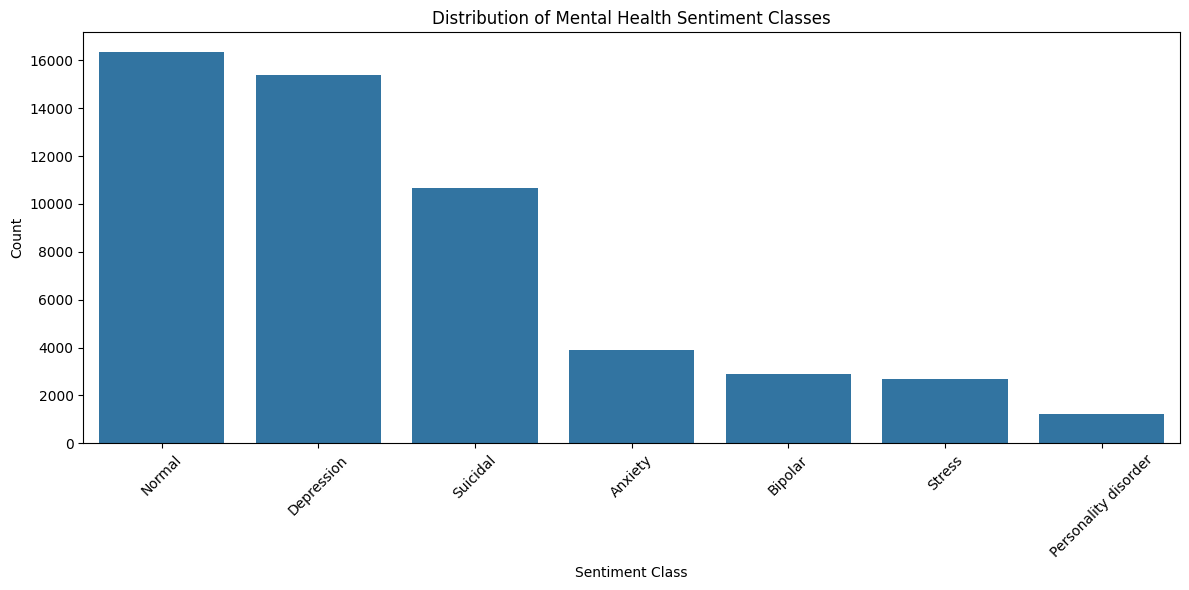

Class distribution:
Normal: 30.83%
Depression: 29.04%
Suicidal: 20.08%
Anxiety: 7.33%
Bipolar: 5.42%
Stress: 5.03%
Personality disorder: 2.26%


In [4]:
# Explore sentiment class distribution
plt.figure(figsize=(12, 6))
sentiment_counts = df['status'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Mental Health Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print class distribution
print("Class distribution:")
class_dist = df['status'].value_counts(normalize=True) * 100
for cls, pct in class_dist.items():
    print(f"{cls}: {pct:.2f}%")

## 3. Text Preprocessing

In [5]:
# Define a preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""

# Apply preprocessing to the text data
df['processed_text'] = df['statement'].apply(preprocess_text)

# Check processed examples
pd.set_option('display.max_colwidth', None)
df[['statement', 'processed_text', 'status']].head()

,statement,processed_text,status
0,oh my gosh,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",trouble sleeping confused mind restless heart all out of tune,Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",all wrong back off dear forward doubt stay in a restless and restless place,Anxiety
3,I've shifted my focus to something else but I'm still worried,ive shifted my focus to something else but im still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",im restless and restless its been a month now boy what do you mean,Anxiety


## 4. Text Analysis

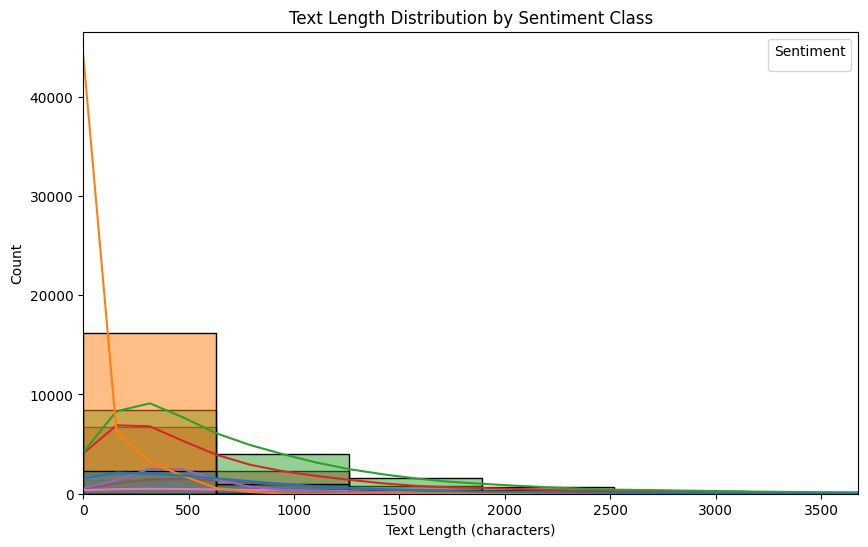

Text length statistics by class:


,mean,median,min,max
status,,,,
Anxiety,723.92,513.0,0,8166
Bipolar,874.15,643.0,0,25278
Depression,825.62,551.0,3,19820
Normal,85.92,47.0,0,1334
Personality disorder,821.99,592.0,0,26826
Stress,563.74,429.0,0,8075
Suicidal,715.65,442.0,0,31499


In [6]:
# Analyze text length distribution
df['text_length'] = df['processed_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='status', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment Class')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.xlim(0, df['text_length'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.legend(title='Sentiment')
plt.show()

# Calculate and display statistics by class
length_stats = df.groupby('status')['text_length'].agg(['mean', 'median', 'min', 'max']).round(2)
print("Text length statistics by class:")
length_stats

In [7]:
nltk.download('punkt_tab')
# Find most common words in each sentiment class
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_word_counts(texts):
    words = []
    for text in texts:
        if isinstance(text, str):
            tokens = word_tokenize(text)
            tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha()]
            tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
            words.extend(tokens)
    return pd.Series(words).value_counts()

# For each sentiment class, find the most common words
for sentiment in df['status'].unique():
    print(f"\nMost common words in '{sentiment}' class:")
    texts = df[df['status'] == sentiment]['processed_text']
    word_counts = get_word_counts(texts)
    print(word_counts.head(15))


Most common words in 'Anxiety' class:


[nltk_data] Downloading package punkt_tab to /home/sukehu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


anxiety    3739
like       3281
feel       2797
ive        2705
get        2126
time       2065
dont       2047
know       1920
day        1864
really     1603
year       1489
pain       1358
feeling    1310
symptom    1302
week       1271
Name: count, dtype: int64

Most common words in 'Normal' class:
like      1268
want      1221
dont      1005
time       925
get        919
really     859
one        801
know       785
day        747
good       680
people     642
work       610
would      604
going      561
year       539
Name: count, dtype: int64

Most common words in 'Depression' class:
like      18357
feel      18269
want      12694
life      11530
know      11141
get       10606
time       9521
even       9150
people     7965
thing      7810
year       7544
day        7468
would      7387
really     7199
friend     6841
Name: count, dtype: int64

Most common words in 'Suicidal' class:
want       11108
like        9170
feel        8549
life        8012
know        6824
would       

# Mental Health Sentiment Analysis - Phase 1

This notebook implements a transformer-based sentiment analysis model for mental health text data. The goal is to accurately classify text into different sentiment categories related to mental health states.

## 1. Setup and Dependencies

In [8]:
# Essential libraries for data processing and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import random
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package punkt to /home/sukehu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sukehu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sukehu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data Loading and Exploration

In [9]:
# Load the dataset
df = pd.read_csv('Dataset/sentiment-analysis-for-mental-health-Combined%20Data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,3,I've shifted my focus to something else but I'm still worried,Anxiety
4,4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


In [10]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


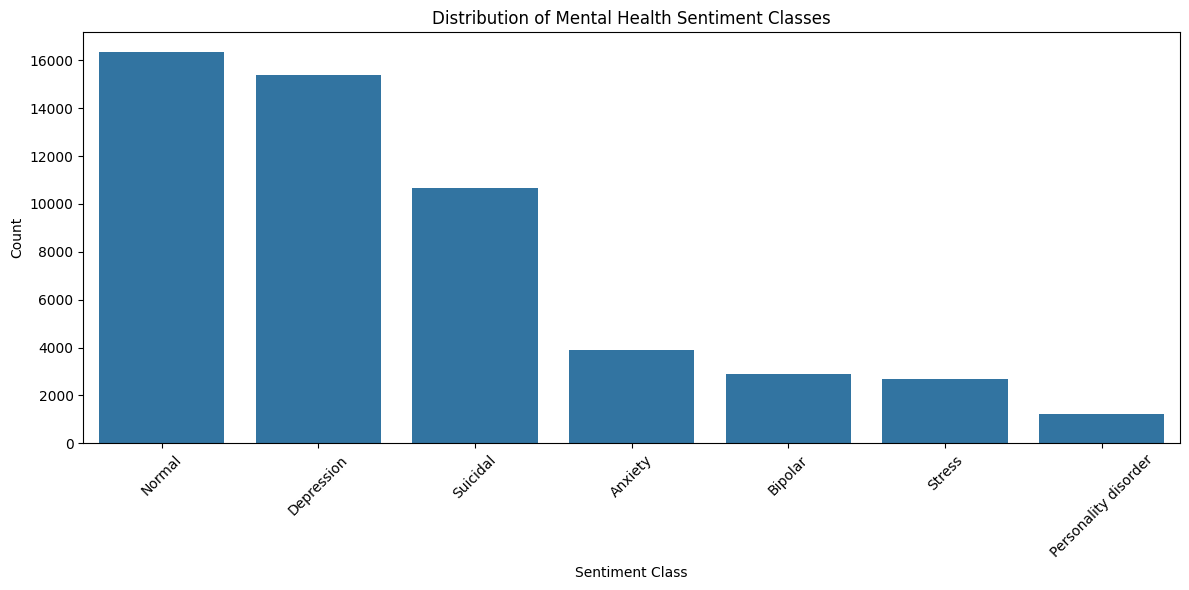

Class distribution:
Normal: 30.83%
Depression: 29.04%
Suicidal: 20.08%
Anxiety: 7.33%
Bipolar: 5.42%
Stress: 5.03%
Personality disorder: 2.26%


In [11]:
# Explore sentiment class distribution
plt.figure(figsize=(12, 6))
sentiment_counts = df['status'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Mental Health Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print class distribution
print("Class distribution:")
class_dist = df['status'].value_counts(normalize=True) * 100
for cls, pct in class_dist.items():
    print(f"{cls}: {pct:.2f}%")

## 3. Text Preprocessing

In [12]:
# Define a preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""

# Apply preprocessing to the text data
df['processed_text'] = df['statement'].apply(preprocess_text)

# Check processed examples
pd.set_option('display.max_colwidth', None)
df[['statement', 'processed_text', 'status']].head()

,statement,processed_text,status
0,oh my gosh,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",trouble sleeping confused mind restless heart all out of tune,Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",all wrong back off dear forward doubt stay in a restless and restless place,Anxiety
3,I've shifted my focus to something else but I'm still worried,ive shifted my focus to something else but im still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",im restless and restless its been a month now boy what do you mean,Anxiety


## 4. Text Analysis

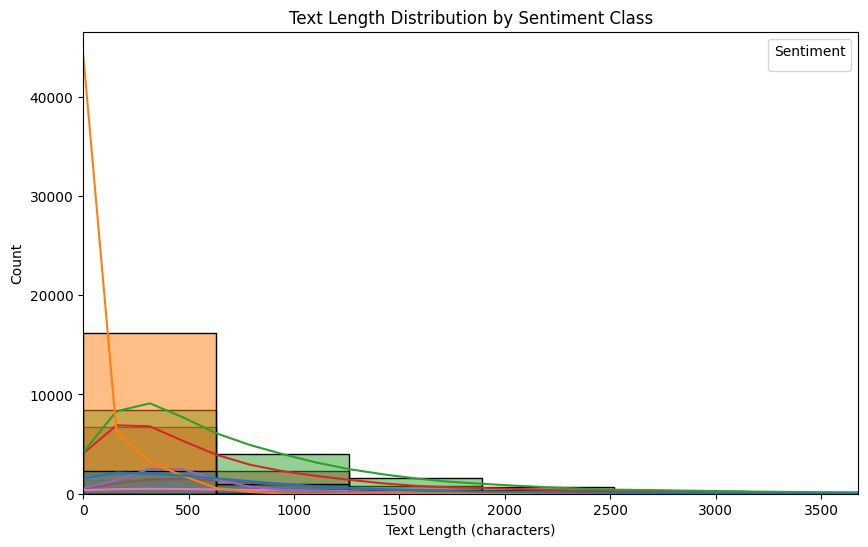

Text length statistics by class:


,mean,median,min,max
status,,,,
Anxiety,723.92,513.0,0,8166
Bipolar,874.15,643.0,0,25278
Depression,825.62,551.0,3,19820
Normal,85.92,47.0,0,1334
Personality disorder,821.99,592.0,0,26826
Stress,563.74,429.0,0,8075
Suicidal,715.65,442.0,0,31499


In [13]:
# Analyze text length distribution
df['text_length'] = df['processed_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='status', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment Class')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.xlim(0, df['text_length'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.legend(title='Sentiment')
plt.show()

# Calculate and display statistics by class
length_stats = df.groupby('status')['text_length'].agg(['mean', 'median', 'min', 'max']).round(2)
print("Text length statistics by class:")
length_stats

## 5. Data Preparation for Modeling

In [14]:
# Create a mapping from categories to numeric labels
label_mapping = {label: i for i, label in enumerate(df['status'].unique())}
df['label'] = df['status'].map(label_mapping)

# Display the mapping
print("Label mapping:")
for category, label in label_mapping.items():
    print(f"{category}: {label}")

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Label mapping:
Anxiety: 0
Normal: 1
Depression: 2
Suicidal: 3
Stress: 4
Bipolar: 5
Personality disorder: 6
Train set size: 37130
Validation set size: 7956
Test set size: 7957


## 6. Transformer Model Implementation

In [15]:
# Define the Custom Dataset class
class MentalHealthSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(text, 
                                 truncation=True,
                                 padding='max_length',
                                 max_length=self.max_length,
                                 return_tensors='pt')
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [16]:
# Load pretrained tokenizer and model
model_name = "distilbert-base-uncased"  # A lightweight transformer model
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = len(label_mapping)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Create datasets
train_dataset = MentalHealthSentimentDataset(
    texts=train_df['processed_text'].tolist(),
    labels=train_df['label'].tolist(),
    tokenizer=tokenizer
)

val_dataset = MentalHealthSentimentDataset(
    texts=val_df['processed_text'].tolist(),
    labels=val_df['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = MentalHealthSentimentDataset(
    texts=test_df['processed_text'].tolist(),
    labels=test_df['label'].tolist(),
    tokenizer=tokenizer
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Define metrics computation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

In [21]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

## 7. Model Training

Now we'll train the model. This could take a while depending on your hardware.

In [22]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
300,0.658400,0.671329,0.748617,0.749300,0.764370,0.748617
600,0.708500,0.664089,0.752011,0.751718,0.756792,0.752011
900,0.546000,0.666916,0.755656,0.747975,0.751208,0.755656
1200,0.526700,0.593385,0.763323,0.760189,0.775436,0.763323
1500,0.510300,0.532953,0.790850,0.788744,0.789091,0.790850
1800,0.542200,0.538509,0.788084,0.785201,0.793380,0.788084
2100,0.537700,0.554065,0.775138,0.772188,0.803567,0.775138
2400,0.402200,0.537941,0.796380,0.793887,0.795582,0.796380
2700,0.462400,0.532358,0.798265,0.799104,0.804069,0.798265
3000,0.431900,0.535015,0.797009,0.795939,0.799577,0.797009


TrainOutput(global_step=11605, training_loss=0.3097170671651149, metrics={'train_runtime': 745.273, 'train_samples_per_second': 249.103, 'train_steps_per_second': 15.571, 'total_flos': 6148691357145600.0, 'train_loss': 0.3097170671651149, 'epoch': 5.0})

## 8. Model Evaluation

In [23]:
# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)
print("Test results:", test_results)

Test results: {'eval_loss': 0.572675883769989, 'eval_accuracy': 0.8011813497549327, 'eval_f1': 0.8023973557901365, 'eval_precision': 0.8051457269528431, 'eval_recall': 0.8011813497549327, 'eval_runtime': 5.227, 'eval_samples_per_second': 1522.301, 'eval_steps_per_second': 23.915, 'epoch': 5.0}


In [24]:
# Get predictions for the test set
test_preds_output = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_output.predictions, axis=1)
test_labels = test_preds_output.label_ids

# Calculate and display detailed classification report
class_names = list(label_mapping.keys())
print(classification_report(test_labels, test_preds, target_names=class_names))

                      precision    recall  f1-score   support

             Anxiety       0.83      0.84      0.84       584
              Normal       0.95      0.94      0.95      2453
          Depression       0.74      0.75      0.74      2311
            Suicidal       0.68      0.71      0.69      1598
              Stress       0.73      0.69      0.71       400
             Bipolar       0.89      0.73      0.80       431
Personality disorder       0.57      0.75      0.65       180

            accuracy                           0.80      7957
           macro avg       0.77      0.77      0.77      7957
        weighted avg       0.81      0.80      0.80      7957



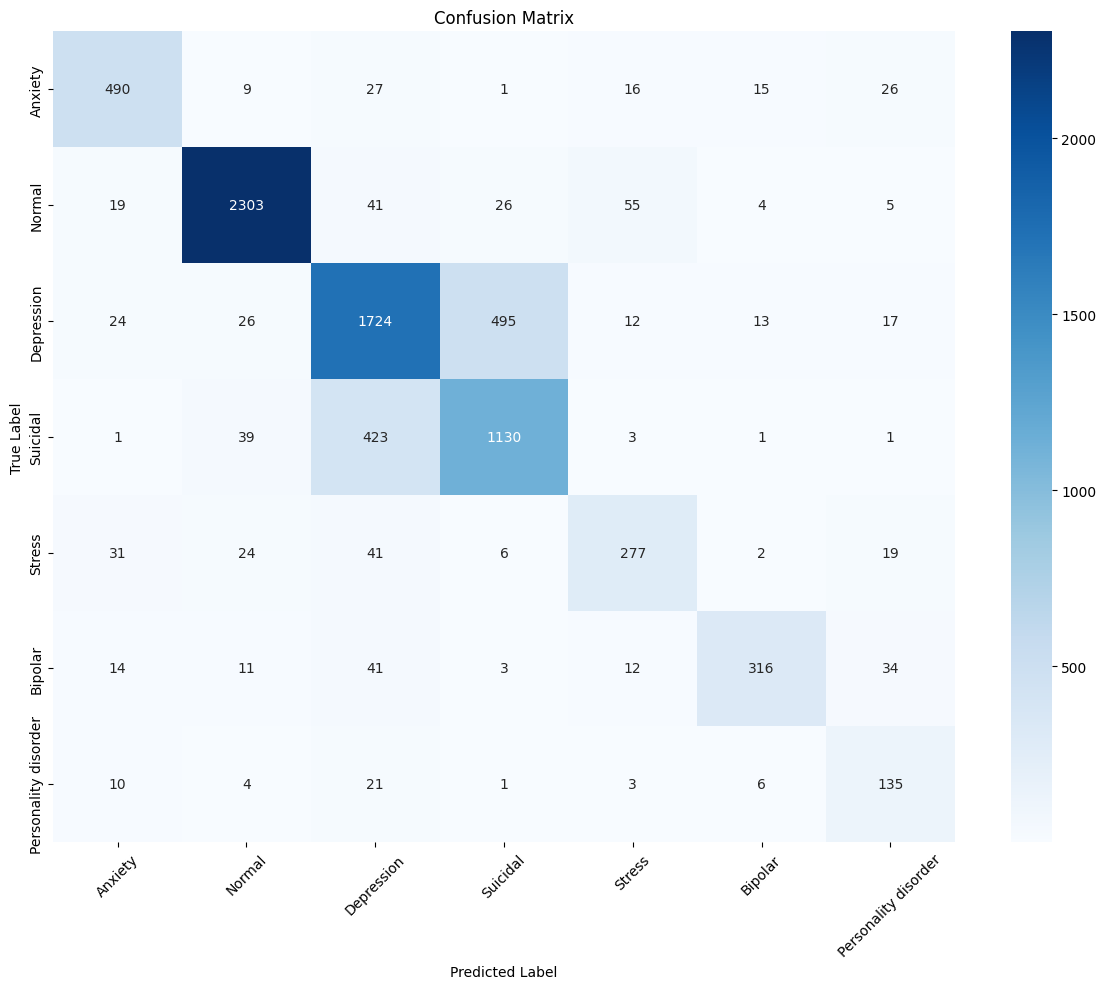

In [25]:
# Create and display confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Error Analysis

In [26]:
# Create a DataFrame with predictions
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_label'] = test_preds
test_df_with_preds['predicted_status'] = test_df_with_preds['predicted_label'].map({v: k for k, v in label_mapping.items()})

# Find misclassified examples
misclassified = test_df_with_preds[test_df_with_preds['label'] != test_df_with_preds['predicted_label']]
print(f"Number of misclassified examples: {len(misclassified)}")

# Display some misclassified examples
misclassified_sample = misclassified.sample(min(10, len(misclassified)))
misclassified_sample[['statement', 'status', 'predicted_status']]

Number of misclassified examples: 1582


,statement,status,predicted_status
10974,"I feel like because my family is such upper class family with tons of money that any pain or suffering I feel is not valid and I am just being ungrateful for all the things I do have and do not deserve to say I feel any pain. I am just a teenager like any other but for some reason I will not allow myself to process and register suffering because I do not think I have the right to feel it sense all my life I have been given everything and not had many struggles, which I cannot control. What do I do? I feel like I do not have the right to say ""I feel pain""",Depression,Suicidal
27771,"And I know it wouldn't completely or even halfway make up for me being an asshole lately, but I want to have some improvement on her life with her being loyal to me despite me not even being able to be there for her as a boyfriend. She's helped me so much. She paid for uber's to job interviews (I only got one callback from a GameStop, they said I'll know if I can go for second interview next week), she paid for laundry one week, she even bought me a pizza once and I have nothing to give back to her. I am near Denver, Colorado. And I am hoping for this to be sent to my GF because she truly deserves something great.",Normal,Stress
18978,"Hey guys, first time posting on here but I feel it is best to get my thoughts out and maybe have some insight from others as I keep a lot of my thoughts inside in person and tend not to share anything with anyone.I first asked the question 'what is the point in life' when I was around 11 to my Mum, she did not give me much of an answer and I cannot even remember what she had said so it could not have been much. When I asked that question it was not me feeling suicidal but just being generally interested but I can remember it very well being the first time I felt truly sad and extremely depressed and almost scared, the world completely changed. After a while, I forgot about it completely until I was 16 which is when my Mum &amp; Dad sadly passed away shortly after one another, not related deaths and both were unexpected which made it more shocking. A few months after my Dad passed I was contemplating suicide, not because I was sad about them passing, I felt I got over it fairly quickly which may sound odd but instead because I could not quite wrap my head around the point of life.I came to the conclusion after endlessly looking into philosophy and general interest in the subject that life is inherently meaningless and in the end we will all die and eventually be forgotten which in itself is bleak and sad. There is of course the argument of there is absolutely no way of knowing the meaning of life, I agree I do not know but I feel at my core that it is completely well and truly meaningless and once we die, it is done, simply done and we will not even know it is over because there will be nothing.This brings me to now, I go through periods of feeling better and then go through really dark, horrible periods such as the one I am having now where I constantly think of ending my life, hurting myself and feeling extremely sad and angry at the fact, at least my fact that life is worthless which kills all joy, all motivation in my life for periods that can be months upon months and what makes me even more mad is that there are others that may not even think anything about life and are so much more happier and enjoying life more than me. I of course am not wanting everyone to suffer, but it just upsets me further that I cannot seem to make myself think that way and simply relax and accept that fact and get on with it I guess.I am truly considering ending my life now as I cannot seem to be happy, I do drag my family down as well as my girlfriend down, she has said to me if I cannot change we will need to end our relationship as she does not want to be sad forever which is obvious and I do not blame her.I am not sure what to do anymore, the constant existential thoughts are very intrusiv

## 10. Model Saving and Loading

In [28]:
# Save the model and tokenizer
output_dir = '../models/mental_health_sentiment_model'
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

# Save label mapping
import json
with open(os.path.join(output_dir, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping, f)

## 11. Model Inference Example

In [29]:
# Function for making predictions on new text
def predict_sentiment(text, model, tokenizer, label_mapping):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Tokenize
    inputs = tokenizer(processed_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
    
    # Map to label
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    predicted_label = reverse_mapping[predicted_class_id]
    
    # Calculate confidence
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
    confidence = probabilities[predicted_class_id].item()
    
    return {
        'sentiment': predicted_label,
        'confidence': confidence,
        'all_probabilities': {reverse_mapping[i]: prob.item() for i, prob in enumerate(probabilities)}
    }

In [30]:
# Test the prediction function on some examples
test_texts = [
    "I'm feeling really anxious today and can't seem to calm down.",
    "Life is beautiful and I'm so grateful for everything I have.",
    "I feel so sad and empty inside, nothing brings me joy anymore.",
    "I'm having thoughts of harming myself and don't know what to do."
]

for text in test_texts:
    prediction = predict_sentiment(text, model, tokenizer, label_mapping)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {prediction['sentiment']}")
    print(f"Confidence: {prediction['confidence']:.4f}")
    print("All probabilities:")
    for sentiment, prob in prediction['all_probabilities'].items():
        print(f"  {sentiment}: {prob:.4f}")
    print("-" * 50)

Text: I'm feeling really anxious today and can't seem to calm down.
Predicted sentiment: Anxiety
Confidence: 0.9959
All probabilities:
  Anxiety: 0.9959
  Normal: 0.0012
  Depression: 0.0010
  Suicidal: 0.0001
  Stress: 0.0012
  Bipolar: 0.0003
  Personality disorder: 0.0003
--------------------------------------------------
Text: Life is beautiful and I'm so grateful for everything I have.
Predicted sentiment: Normal
Confidence: 0.9903
All probabilities:
  Anxiety: 0.0013
  Normal: 0.9903
  Depression: 0.0042
  Suicidal: 0.0021
  Stress: 0.0005
  Bipolar: 0.0009
  Personality disorder: 0.0006
--------------------------------------------------
Text: I feel so sad and empty inside, nothing brings me joy anymore.
Predicted sentiment: Depression
Confidence: 0.6537
All probabilities:
  Anxiety: 0.0005
  Normal: 0.0005
  Depression: 0.6537
  Suicidal: 0.3431
  Stress: 0.0014
  Bipolar: 0.0004
  Personality disorder: 0.0004
--------------------------------------------------
Text: I'm having 

## 12. Conclusion and Next Steps

In this notebook, we have:

1. Loaded and explored the mental health sentiment dataset
2. Performed text preprocessing
3. Analyzed the text data and class distribution
4. Prepared the data for modeling
5. Implemented a transformer-based model using DistilBERT
6. Trained and evaluated the model
7. Performed error analysis
8. Saved the model for future use
9. Demonstrated how to make predictions on new text

Next steps for improving the model could include:

1. Trying different transformer models (e.g., RoBERTa, BERT, ALBERT)
2. Fine-tuning hyperparameters
3. Using more sophisticated preprocessing techniques
4. Implementing data augmentation techniques
5. Exploring ensemble methods
6. Addressing class imbalance issues
7. Adding more explainability features

These improvements will be explored in Phase 2 of this project.